In [38]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from sklearn.decomposition import PCA
from sklearn import manifold
import pickle;

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [3]:
import spacy
nlp  = spacy.load('en_core_web_md')

In [4]:
nltk.download('stopwords')
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /Users/avi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
file_name = '/Users/avi/Dropbox/Insight/Project/insight_project/data/charity_data_cleaned_temp.csv'
charity_data = pd.read_csv(file_name)

In [8]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [110]:
'''
Write a function to run word embedding pre-processing on df
'''
def word_embed_dim_reduce(df,pca_comp =8,word_min=5, word_max_perc=.2 ):
    
    #Extract mission descritptions
    mission_text = df['description'].astype('str')
    
    #Pre-process documents (remove stop words and lamentize)
    processed_docs = []

    for doc in mission_text:
        processed_docs.append(preprocess(doc))
    
    #Create dictionary from corpus
    docs_dict = Dictionary(processed_docs)
    docs_dict.filter_extremes(no_below=word_min, no_above=word_max_perc)
    docs_dict.compactify()
    
    #Convert docs into tf-idf vectors
    docs_corpus = [docs_dict.doc2bow(doc) for doc in processed_docs]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])
    
    num_docs= np.shape(docs_vecs)[0]
    num_words = np.shape(docs_vecs)[1]

    print("Total # of docs: {}".format(num_docs))
    print("Total # of words in dict: {}".format(num_words))
    
    #For each word in dict obtain embedding vectore (Glove vectors)
    tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
    
    # Weigth tf-idf by glove vectors 
    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
    
    #Perform pca on document matrix
    docs_pca = PCA(n_components=pca_comp).fit_transform(docs_emb)
    
    #Project into 2D space
    tsne = manifold.TSNE()
    viz = tsne.fit_transform(docs_pca)
    
    #Add projected dimensions to df
    df['pca_1'] = viz[:,0]
    df['pca_2'] = viz[:,1]
    
    return df
    

In [106]:
charity_pca = word_embed_dim_reduce(charity_data,pca_comp =8,word_min=5, word_max_perc=.2)

Total # of docs:8370
Total # of words in dict:3749


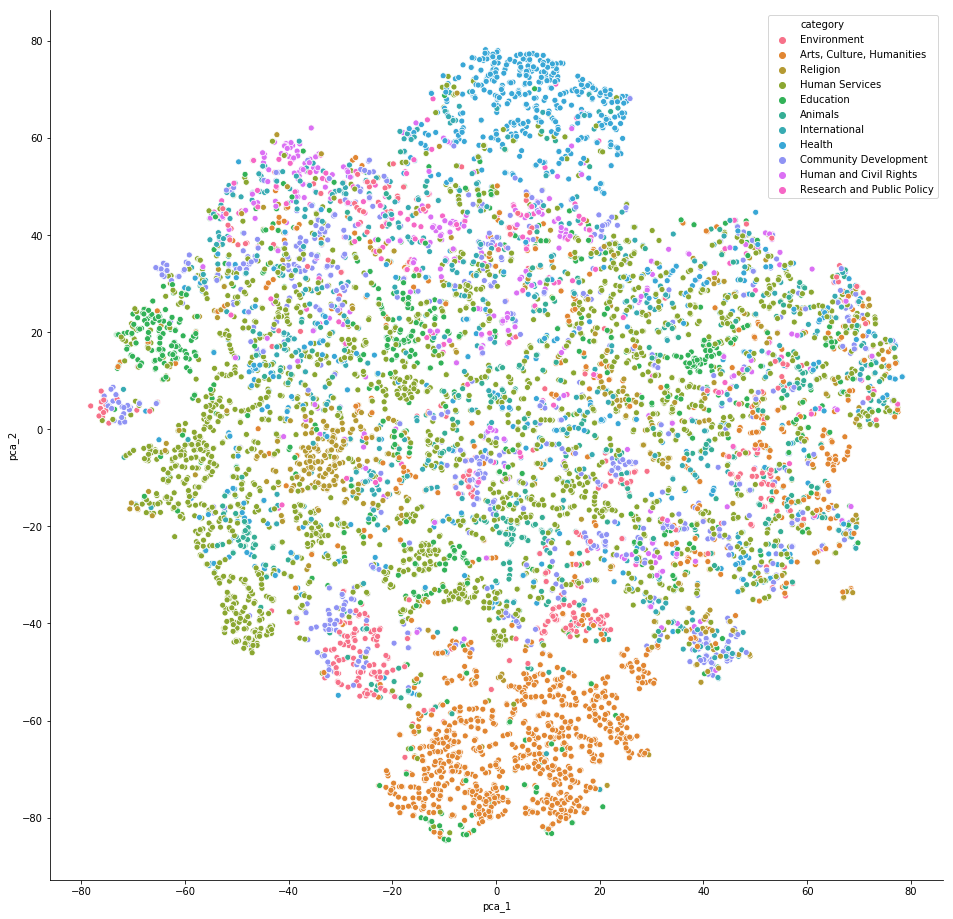

In [93]:
plt.figure(figsize=(16, 16))
ax = sns.scatterplot(x="pca_1", y="pca_2",hue = 'category', data=charity_pca)
sns.despine()

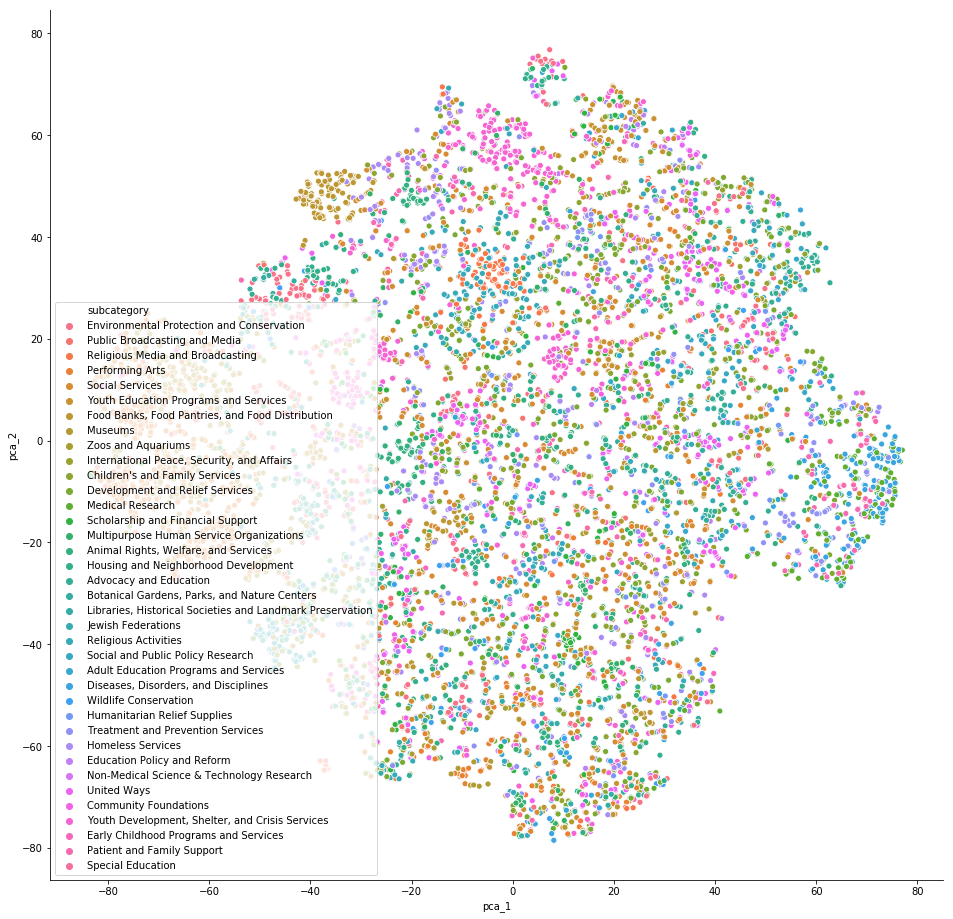

In [66]:
plt.figure(figsize=(16, 16))
ax = sns.scatterplot(x="pca_1", y="pca_2",hue = 'subcategory', data=charity_pca)
sns.despine()

In [109]:
human_services = charity_data[charity_data['category'] == 'Human Services']
hs_pca = word_embed_dim_reduce(human_services,pca_comp =8,word_min=5, word_max_perc=.2)

Total # of docs:2369
Total # of words in dict:1795


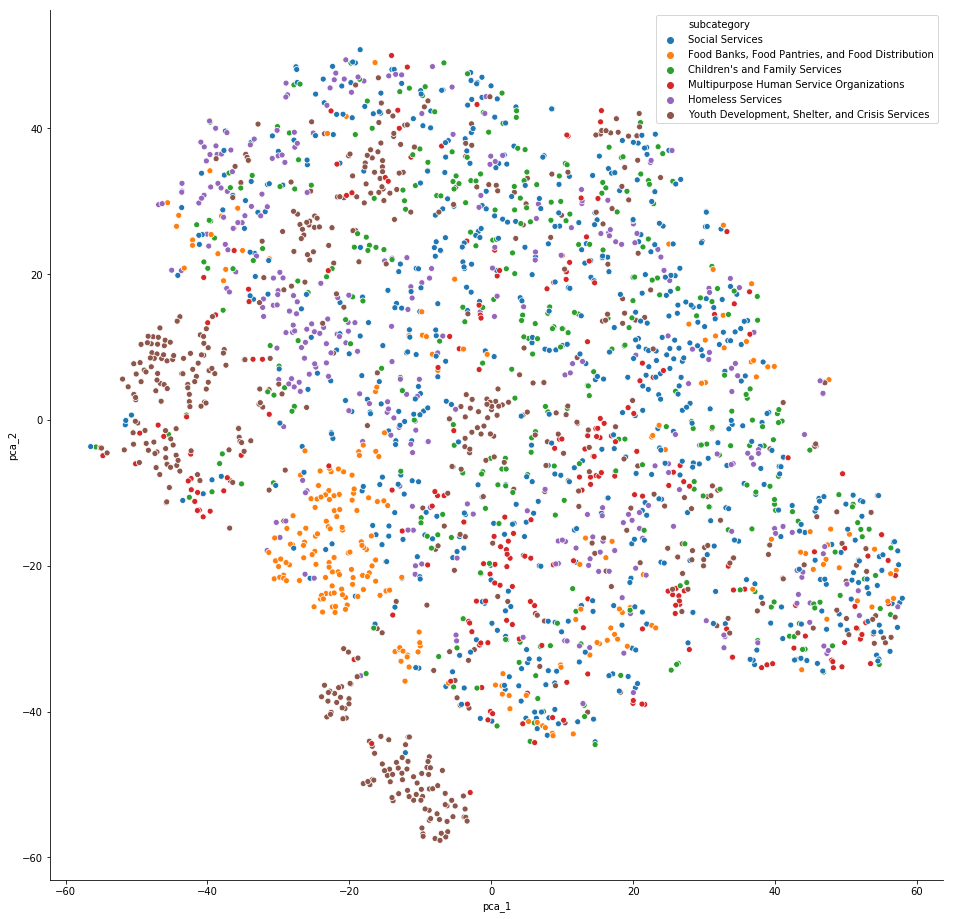

In [111]:
plt.figure(figsize=(16, 16))
ax = sns.scatterplot(x="pca_1", y="pca_2",hue = 'subcategory', data=hs_pca)
sns.despine()

In [112]:
international = charity_data[charity_data['category'] == 'International']
int_pca = word_embed_dim_reduce(international,pca_comp =8,word_min=5, word_max_perc=.2)

Total # of docs: 608
Total # of words in dict: 858


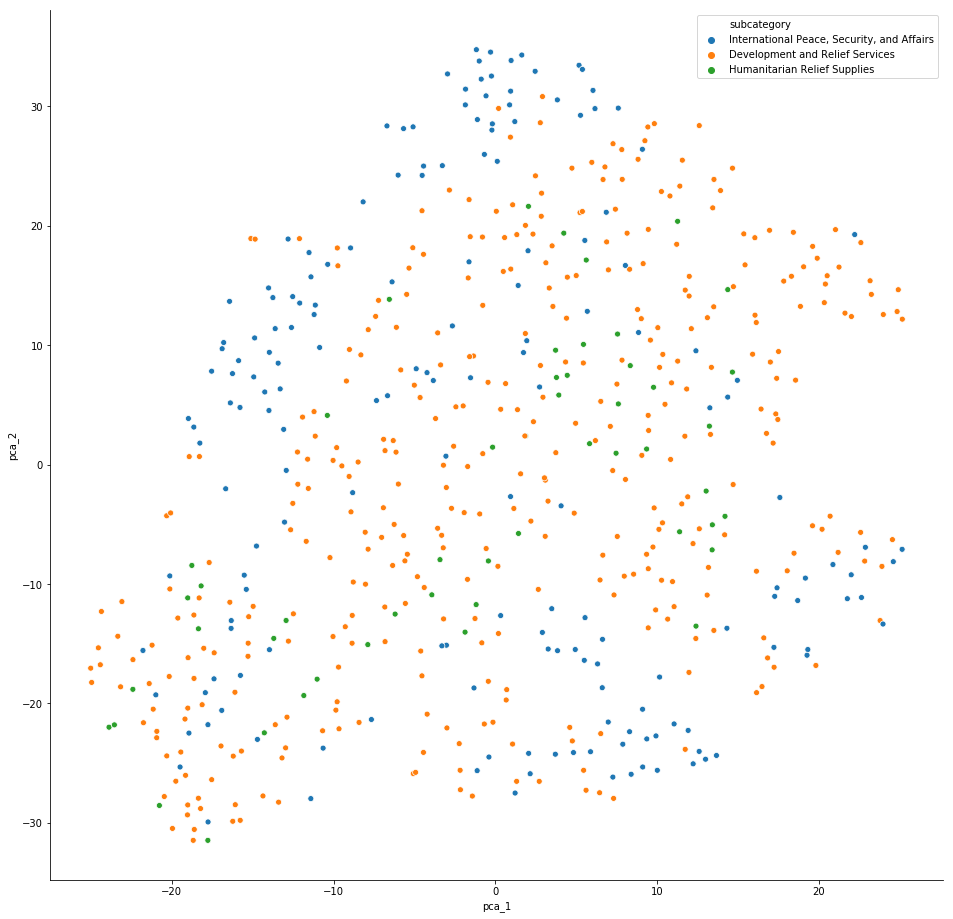

In [113]:
plt.figure(figsize=(16, 16))
ax = sns.scatterplot(x="pca_1", y="pca_2",hue = 'subcategory', data=int_pca)
sns.despine()